In [1]:
import pandas as pd
import numpy as np
import os
from options import *
import cv2
import torch
import matplotlib.pyplot as plt
import dlib


video_path = "./dataset/train/training80_01/_uNup91ZYw0.002.mp4"
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print("打开视频{}失败！".format(video_path))
total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)

In [2]:
index = torch.rand(6)
per = total_frames // 6
print(index,per)
for i in range(6):
    index[i] = index[i]*per + i*per
index = index.to(dtype=torch.int)
index

tensor([0.4653, 0.0604, 0.4808, 0.7729, 0.2358, 0.5223]) 61.0


tensor([ 28,  64, 151, 230, 258, 336], dtype=torch.int32)

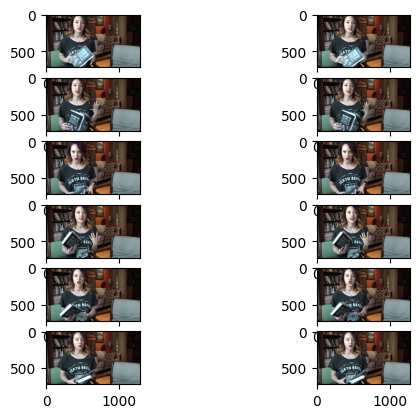

(6, 2, 720, 1280, 3)

In [3]:
frames_list = np.zeros((6, 2, 720, 1280, 3), dtype=np.uint8)
for i, ind in enumerate(index):
    if ind == 0:
        ind =1
    video.set(cv2.CAP_PROP_POS_FRAMES, float(ind))
    _, cur = video.read()
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
    frames_list[i, 0] = cur
    video.set(cv2.CAP_PROP_POS_FRAMES, float(ind-1))
    _, pre = video.read()
    plt.subplot(6, 2, 2*i+2)
    plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
    frames_list[i,1] = pre
plt.show()
frames_list.shape

获取光流信息

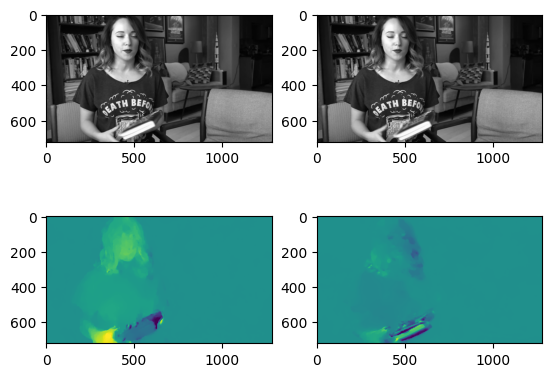

(6, 720, 1280, 2)

In [4]:
def compute_TVL1(prev, curr, bound=15):
    TVL1 = cv2.optflow.DualTVL1OpticalFlow_create()
    flow = TVL1.calc(prev, curr, None)

    assert flow.dtype == np.float32

    flow = (flow + bound) * (255.0 / (2 * bound))
    flow = np.round(flow).astype(int)
    flow[flow >= 255] = 255
    flow[flow <= 0] = 0

    return flow
flows_list = np.zeros((len(frames_list), 720, 1280, 2), dtype=np.uint8)
for i, frames in enumerate(frames_list):
    cur = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    pre = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(cur, cv2.COLOR_BGR2RGB))
    plt.subplot(2, 2 ,2)
    plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
    flow = compute_TVL1(pre, cur)
    flows_list[i] = flow
    plt.subplot(2, 2, 3)
    plt.imshow(flow[:,:,0])
    plt.subplot(2, 2, 4)
    plt.imshow(flow[:,:,1])
plt.show()
flows_list.shape

获取人脸区域

In [20]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

from torchvision import transforms
def get_image_face(frames_list, flows_list):
    cropped_face_rgb = []*6
    cropped_face_flow = []*6
    face_detector = dlib.get_frontal_face_detector()
    height, width = frames_list.shape[2:4]
    frame_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([224, 224]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
        ])
    flow_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([224, 224]),
        ])
    
    for i, frame in enumerate(frames_list):
        gray = cv2.cvtColor(frame[0], cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1)
        if len(faces):
            # For now only take biggest face
            face = faces[0]

            # --- Prediction ---------------------------------------------------
            # Face crop with dlib and bounding box scale enlargement
            x, y, size = get_boundingbox(face, width, height)
            cropped_face_rgb.append(frame_transform
                                    (frame[0][y:y+size, x:x+size, :]))
            cropped_face_flow.append(flow_transform
                                     (flows_list[i][y:y+size, x:x+size, :]))
    return cropped_face_rgb, cropped_face_flow
    
cropped_face_rgb, cropped_face_flow = get_image_face(frames_list=frames_list,
                                                            flows_list=flows_list)
# print(cropped_face_rgb.shape, cropped_face_flow.shape)
cropped_face_rgb, cropped_face_flow = np.array(cropped_face_rgb), np.array(
    cropped_face_flow
)
cropped_face_flow.shape, cropped_face_rgb.shape
# plt.subplot(3, 1, 1)
# plt.imshow(cropped_face_rgb[0])
# plt.subplot(3, 1, 2)
# plt.imshow(cropped_face_flow[0][:, :, 0])
# plt.subplot(3, 1, 3)
# plt.imshow(cropped_face_flow[0][:, :, 1])
# plt.show()
# from torchvision import transforms
# cropped_face_flow

/raid5/chenjunlin/conda_min/envs/big5/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


((6, 2, 224, 224), (6, 3, 224, 224))

In [6]:
from model import network
import torch.nn as nn

try:
    model = network.func_dict['resnet18']
except:
    print("model:{} isn't existed".format('resnet18'))
instance = model(pretrained=True, progress=True)
in_features = instance.fc.in_features
instance.fc = nn.Linear(in_features=in_features, out_features=240)
print(instance)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
from model import ViT
model = ViT.ViT(num_patches=6, num_classes=5, dim=432, depth=3, heads=3, mlp_dim=768)
input = torch.rand((32, 6, 432))
result = model(input)
result

tensor([[ 0.1913,  0.0409,  0.1905,  0.9140, -0.2923],
        [ 0.2150,  0.0032,  0.1186,  0.9020, -0.3058],
        [ 0.1951,  0.0476,  0.1234,  0.8635, -0.2631],
        [ 0.1771,  0.0275,  0.1349,  0.9145, -0.2999],
        [ 0.2256,  0.0306,  0.1503,  0.9482, -0.2895],
        [ 0.2038,  0.0176,  0.1318,  0.8609, -0.3148],
        [ 0.2198,  0.0178,  0.1171,  0.8632, -0.3082],
        [ 0.2182,  0.0404,  0.1437,  0.9118, -0.2851],
        [ 0.1746,  0.0703,  0.1269,  0.8796, -0.2638],
        [ 0.2019,  0.0484,  0.1426,  0.8885, -0.2957],
        [ 0.2030, -0.0021,  0.1199,  0.8828, -0.3073],
        [ 0.2310,  0.0117,  0.1538,  0.9207, -0.2754],
        [ 0.1858,  0.0363,  0.1745,  0.8560, -0.2810],
        [ 0.1351,  0.0280,  0.1189,  0.8956, -0.2532],
        [ 0.2320,  0.0464,  0.1142,  0.8578, -0.3003],
        [ 0.1683,  0.0370,  0.1614,  0.8747, -0.3608],
        [ 0.1855,  0.0179,  0.1501,  0.9129, -0.3439],
        [ 0.2091,  0.0348,  0.1376,  0.8586, -0.3002],
        [ 